<a href="https://colab.research.google.com/github/zorocrit/2025-Graduation-Project/blob/main/flank_hyundong_2503311718.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycolmap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 89.0 MB/s eta 0:00:00


In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
# This mounts your Google Drive to the Colab VM.
# from google.colab import drive

In [4]:
# drive.mount('/content/drive/')

In [5]:
# FOLDERNAME = 'MyDrive/Flank_Hyundong'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

In [7]:
# import sys
# sys.path.append('/content/drive/{}'.format(FOLDERNAME))

# # Change dariectory to current folder
# %cd /content/drive/$FOLDERNAME

/content/drive/MyDrive/Flank_Hyundong


(52, 270, 480, 3) (52, 4, 4) 415.69219381653056


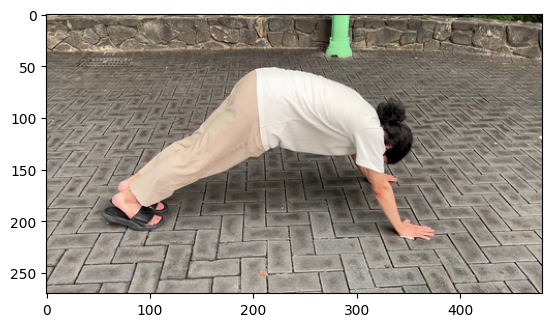

In [8]:
data = np.load('llff_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[51], poses[51]
images = images[:50,...,:3]
poses = poses[:50]

plt.imshow(testimg)
plt.show()

In [20]:
# 전역 변수
L_embed = 6

def posenc(x):
    # 입력을 float32로 캐스팅
    x = tf.cast(x, tf.float32)
    rets = [x]
    for i in range(L_embed):
        for fn in [tf.sin, tf.cos]:
            rets.append(fn(2.**i * x))
    return tf.concat(rets, -1)

embed_fn = posenc

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu: tf.keras.layers.Dense(W, activation=act, dtype=tf.float32)
    # 입력 shape를 (3 + 3*2*L_embed,)로 지정하고, dtype을 명시합니다.
    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed,), dtype=tf.float32)
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i % 4 == 0 and i > 0:
            outputs = tf.keras.layers.Lambda(lambda x: tf.concat(x, axis=-1))([outputs, inputs])
    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def pose_spherical(theta, phi, radius):
    """
    주어진 spherical 좌표(θ, φ, 반경)를 바탕으로 카메라-투-월드(c2w) 4x4 pose 행렬을 생성합니다.

    theta: y축을 중심으로 회전 (deg)
    phi: x축을 중심으로 회전 (deg)
    radius: 원점으로부터의 거리
    """
    theta = np.deg2rad(theta)
    phi = np.deg2rad(phi)
    # 모든 np.array 생성 시 dtype=np.float32 지정
    trans_t = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, radius],
        [0, 0, 0, 1]
    ], dtype=np.float32)
    rot_phi = np.array([
        [1, 0, 0, 0],
        [0, np.cos(phi), -np.sin(phi), 0],
        [0, np.sin(phi),  np.cos(phi), 0],
        [0, 0, 0, 1]
    ], dtype=np.float32)
    rot_theta = np.array([
        [np.cos(theta), 0, -np.sin(theta), 0],
        [0, 1, 0, 0],
        [np.sin(theta), 0,  np.cos(theta), 0],
        [0, 0, 0, 1]
    ], dtype=np.float32)
    c2w = rot_theta @ rot_phi @ trans_t
    fix = np.array([
        [1,  0,  0, 0],
        [0, -1,  0, 0],
        [0,  0, -1, 0],
        [0,  0,  0, 1]
    ], dtype=np.float32)
    c2w = fix @ c2w
    return c2w  # 반환되는 c2w는 float32

def get_rays(H, W, focal, c2w):
    # c2w를 float32 텐서로 변환
    c2w = tf.convert_to_tensor(c2w, dtype=tf.float32)
    # focal도 float32로 변환
    focal = tf.cast(focal, tf.float32)

    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32),
                       tf.range(H, dtype=tf.float32),
                       indexing='xy')
    dirs = tf.stack([(i - W * 0.5) / focal,
                     -(j - H * 0.5) / focal,
                     -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., tf.newaxis, :] * c2w[:3, :3], -1)
    rays_o = tf.broadcast_to(c2w[:3, -1], tf.shape(rays_d))
    return rays_o, rays_d

def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):
    def batchify(fn, chunk=1024):
        return lambda inputs: tf.concat([fn(inputs[i:i+chunk])
                                         for i in range(0, tf.shape(inputs)[0], chunk)], 0)

    # near와 far를 float32로 변환하고, tf.linspace에 dtype을 명시합니다.
    z_vals = tf.linspace(tf.cast(near, tf.float32), tf.cast(far, tf.float32), N_samples)

    if rand:
        shape_rays = tf.shape(rays_o)[:-1]
        random_offset = tf.random.uniform(tf.concat([shape_rays, [N_samples]], axis=0), dtype=tf.float32)
        z_vals = z_vals + random_offset * (far - near) / N_samples

    pts = rays_o[..., tf.newaxis, :] + rays_d[..., tf.newaxis, :] * z_vals[..., :, tf.newaxis]

    pts_flat = tf.reshape(pts, [-1, 3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, tf.concat([tf.shape(pts)[:-1], [4]], axis=0))

    sigma_a = tf.nn.relu(raw[..., 3])
    rgb = tf.math.sigmoid(raw[..., :3])

    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1],
                       tf.broadcast_to(tf.constant([1e10], dtype=tf.float32), tf.shape(z_vals[..., :1]))], -1)
    alpha = 1.0 - tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.0 - alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[..., tf.newaxis] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

In [21]:
# 모델 초기화
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 32
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

# 아래 변수들은 여러분의 환경에 맞게 정의되어야 합니다.
# 예시로 images, poses, H, W, focal, testpose, testimg 등이 있다고 가정합니다.
# (예: images와 poses는 numpy 배열, H와 W는 이미지 높이와 너비, focal은 첫 번째 이미지의 focal 값)

import time
t = time.time()
for i in range(N_iters+1):
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]  # target은 float32여야 합니다.
    pose = poses[img_i]     # pose도 float32여야 합니다.
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2.0, far=6.0, N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if i % i_plot == 0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Holdout view 렌더링
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2.0, far=6.0, N_samples=N_samples)
        loss_val = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10.0 * tf.math.log(loss_val) / tf.math.log(10.0)

        psnrs.append(psnr.numpy())
        iternums.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(rgb.numpy())
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul] name: 